# Walmart Challenge

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb # for modelling
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [3]:
df_train = pd.read_csv('data/train.csv')
df_train = df_train.set_index('Date')
df_train.index = pd.to_datetime(df_train.index)
df_train.sort_index(inplace=True)
df_train

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
Date,,,,,,,,,,,,,,,
2010-02-05,20,44,10130.02,False,25.92,2.784,NaN,NaN,NaN,NaN,NaN,204.247194,8.187,A,203742
2010-02-05,14,31,3798.40,False,27.31,2.784,NaN,NaN,NaN,NaN,NaN,181.871190,8.992,A,200898
2010-02-05,12,94,4.96,False,49.47,2.962,NaN,NaN,NaN,NaN,NaN,126.442065,13.975,B,112238
2010-02-05,41,40,47546.05,False,30.27,2.580,NaN,NaN,NaN,NaN,NaN,189.381697,7.541,A,196321
2010-02-05,28,4,33057.95,False,49.47,2.962,NaN,NaN,NaN,NaN,NaN,126.442065,13.975,A,206302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-10-26,38,34,5.96,False,65.95,4.301,148.32,6.73,3.05,NaN,344.78,131.193097,10.199,C,39690
2012-10-26,18,60,153.00,False,56.09,3.917,5430.61,128.31,50.00,822.64,969.64,138.728161,8.243,B,120653
2012-10-26,14,2,61378.96,False,58.85,3.882,9258.41,99.19,117.84,1489.28,1433.31,192.308899,8.667,A,200898


Holidays do have a higher sales value than non-holiday weeks, but this difference is smaller than expected

<Axes: xlabel='IsHoliday', ylabel='Weekly_Sales'>

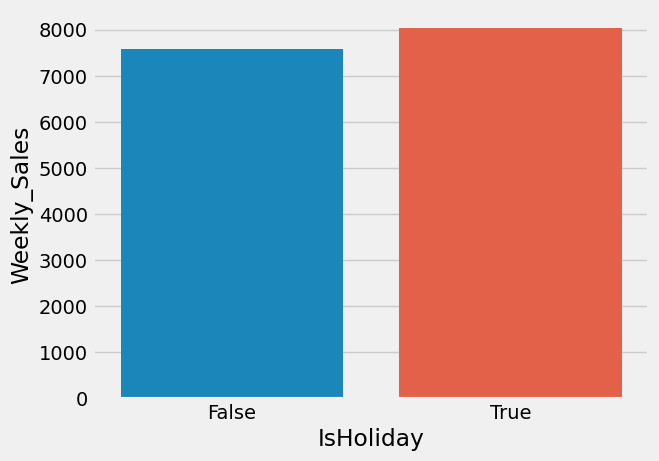

In [4]:
holiday = df_train[['Weekly_Sales','IsHoliday']].groupby(['IsHoliday']).median()
holiday

sns.barplot(x=holiday.index,y=holiday.Weekly_Sales)

## Plotting the dataframe

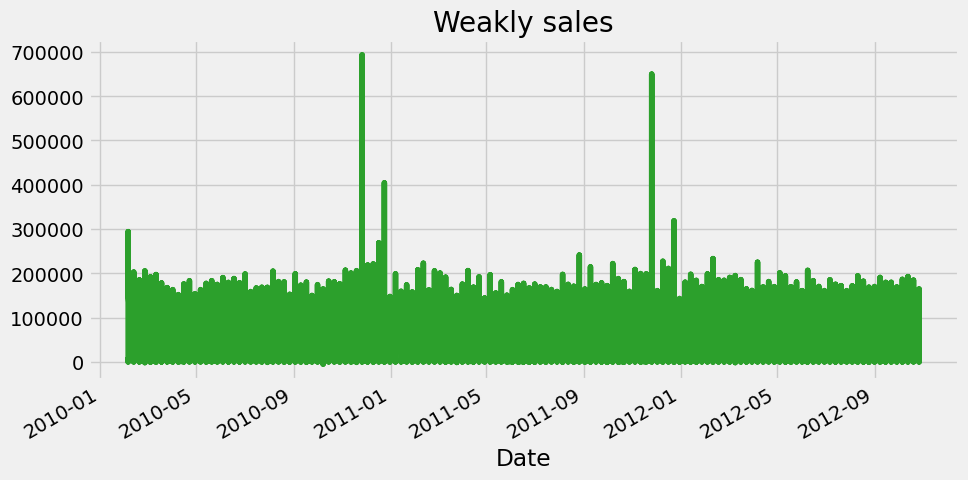

In [5]:
df_train.sort_index(ascending=True,inplace=True)
df_train["Weekly_Sales"].plot(color=color_pal[2],title="Weakly sales",figsize=(10,5))
plt.show()

<Axes: xlabel='Date', ylabel='Weekly_Sales'>

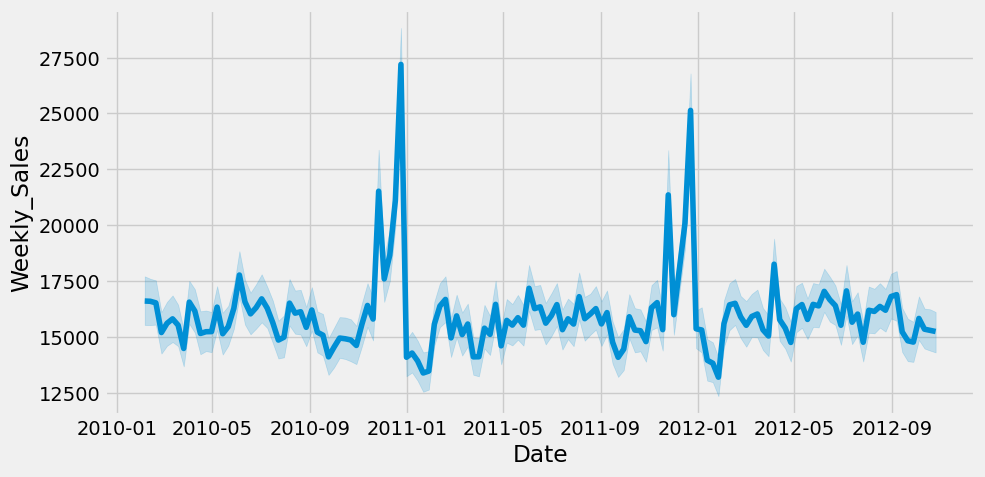

In [6]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x=df_train.index,y=df_train.Weekly_Sales)

## Checking below, by counting the total stores registration of each day.

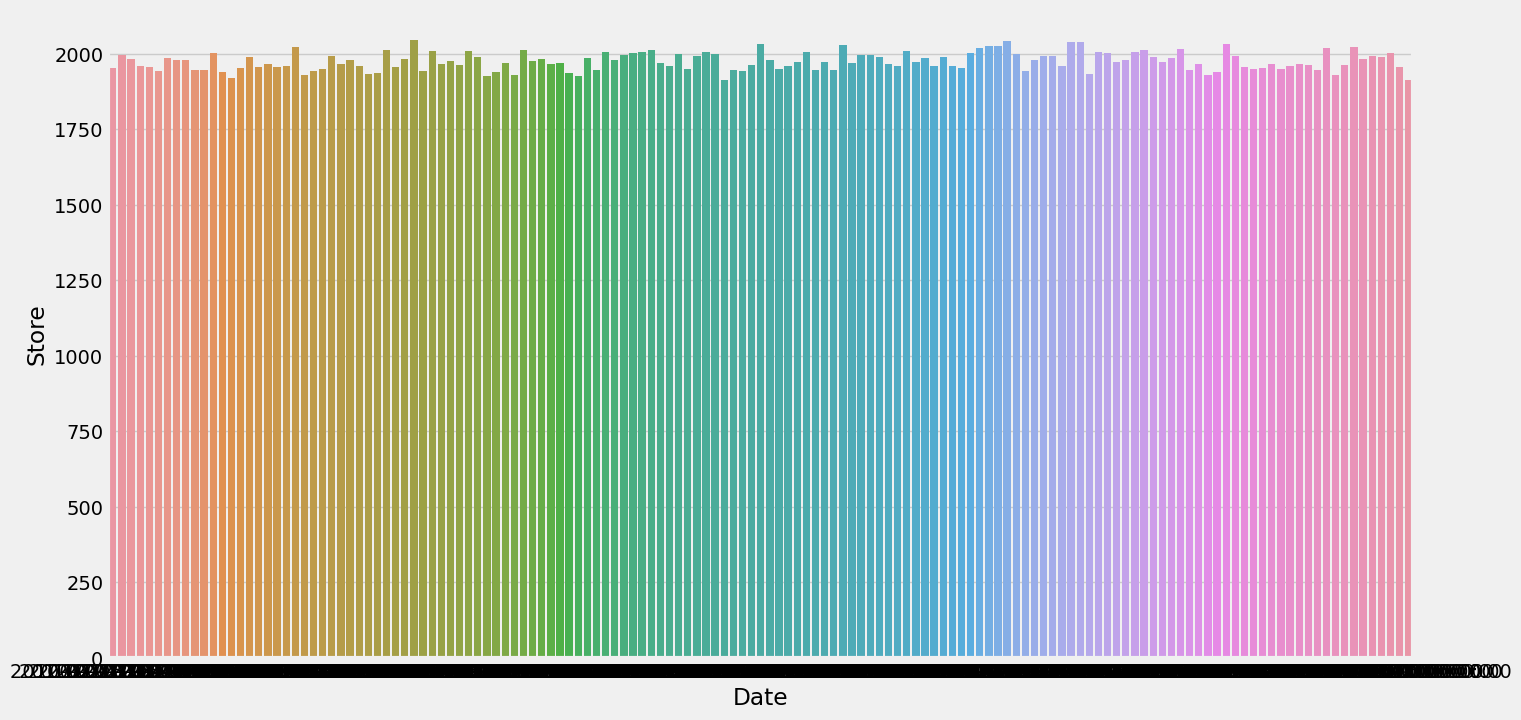

In [7]:
df_train=df_train.reset_index()
registers_per_day = df_train[['Store','Dept','Date']].groupby(['Date']).count()
fig, axs = plt.subplots(figsize=(15,8))
sns.barplot(x=registers_per_day.index,y=registers_per_day.Store)
df_train = df_train.set_index('Date')
plt.show()

## Feature creation

In [8]:
def modify_categories(x: str):
    if x == 'A':
        return 1
    if x == 'B':
        return 2
    return 3

def create_features(df):
    df['Week'] = pd.to_datetime(df.index).isocalendar().week
    df['Year'] = pd.to_datetime(df.index).isocalendar().year

    df['Week'] = df['Week'].astype('int')
    df['Year'] = df['Year'].astype('int')

    df['ModType'] = df['Type'].apply(lambda x: modify_categories(x)) 
    df['IsChristmas'] = df['Week'].apply(lambda x: 1 if x == 51 else 0)
    df['IsThanksgiving'] = df['Week'].apply(lambda x: 1 if x == 47 else 0)
    
    return df

In [9]:
df_train = create_features(df_train)
df_train

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Week,Year,ModType,IsChristmas,IsThanksgiving
Date,,,,,,,,,,,,,,,,,,,,
2010-02-05,20,44,10130.02,False,25.92,2.784,NaN,NaN,NaN,NaN,NaN,204.247194,8.187,A,203742,5,2010,1,0,0
2010-02-05,14,31,3798.40,False,27.31,2.784,NaN,NaN,NaN,NaN,NaN,181.871190,8.992,A,200898,5,2010,1,0,0
2010-02-05,12,94,4.96,False,49.47,2.962,NaN,NaN,NaN,NaN,NaN,126.442065,13.975,B,112238,5,2010,2,0,0
2010-02-05,41,40,47546.05,False,30.27,2.580,NaN,NaN,NaN,NaN,NaN,189.381697,7.541,A,196321,5,2010,1,0,0
2010-02-05,28,4,33057.95,False,49.47,2.962,NaN,NaN,NaN,NaN,NaN,126.442065,13.975,A,206302,5,2010,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-10-26,38,34,5.96,False,65.95,4.301,148.32,6.73,3.05,NaN,344.78,131.193097,10.199,C,39690,43,2012,3,0,0
2012-10-26,18,60,153.00,False,56.09,3.917,5430.61,128.31,50.00,822.64,969.64,138.728161,8.243,B,120653,43,2012,2,0,0
2012-10-26,14,2,61378.96,False,58.85,3.882,9258.41,99.19,117.84,1489.28,1433.31,192.308899,8.667,A,200898,43,2012,1,0,0


In [10]:
df_train.columns

Index(['Store', 'Dept', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'Week', 'Year',
       'ModType', 'IsChristmas', 'IsThanksgiving'],
      dtype='object')

In [11]:
features = ['Store', 'Dept', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Size', 'Week', 'Year','ModType', 'IsChristmas', 'IsThanksgiving']
target = 'Weekly_Sales'

X_train = df_train[features]
Y_train = df_train[target]

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 282451 entries, 2010-02-05 to 2012-10-26
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Store           282451 non-null  int64  
 1   Dept            282451 non-null  int64  
 2   IsHoliday       282451 non-null  bool   
 3   Temperature     282451 non-null  float64
 4   Fuel_Price      282451 non-null  float64
 5   MarkDown1       100520 non-null  float64
 6   MarkDown2       74232 non-null   float64
 7   MarkDown3       91521 non-null   float64
 8   MarkDown4       90031 non-null   float64
 9   MarkDown5       101029 non-null  float64
 10  CPI             282451 non-null  float64
 11  Unemployment    282451 non-null  float64
 12  Size            282451 non-null  int64  
 13  Week            282451 non-null  int32  
 14  Year            282451 non-null  int32  
 15  ModType         282451 non-null  int64  
 16  IsChristmas     282451 non-null  int64  

## Train / Test Split for XGB regressor

C:\Users\USER\AppData\Local\Temp\ipykernel_17356\3627496717.py:7: UserWarning: The label '_nolegend_' of <matplotlib.collections.PolyCollection object at 0x000001E6142F8B10> starts with '_'. It is thus excluded from the legend.
  ax.legend(['Training Set','_nolegend_','Test Set','_nolegend_'])
C:\Users\USER\AppData\Local\Temp\ipykernel_17356\3627496717.py:7: UserWarning: The label '_nolegend_' of <matplotlib.collections.PolyCollection object at 0x000001E6142C8610> starts with '_'. It is thus excluded from the legend.
  ax.legend(['Training Set','_nolegend_','Test Set','_nolegend_'])


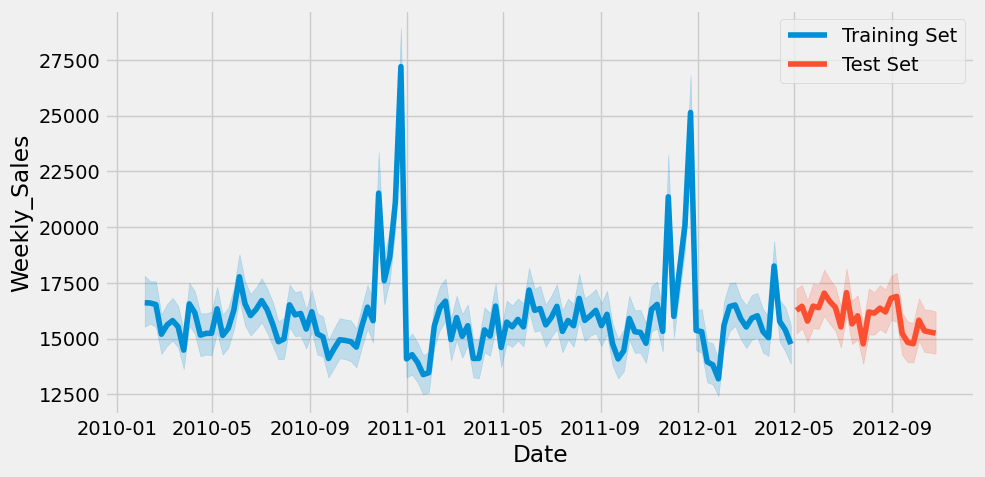

In [13]:
train = df_train.loc[df_train.index < "2012-05-01"]
test = df_train.loc[df_train.index >= "2012-05-01"]

fig, ax = plt.subplots(figsize=((10,5)))
sns.lineplot(x=train.index,y=train.Weekly_Sales)
sns.lineplot(x=test.index,y=test.Weekly_Sales)
ax.legend(['Training Set','_nolegend_','Test Set','_nolegend_'])
plt.show()

In [14]:
reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',n_estimators=500,
                       max_depth=15)
reg.fit(train[features], train[target],verbose = 100)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [15]:
test_predict = reg.predict(test[features])

C:\Users\USER\AppData\Local\Temp\ipykernel_17356\2800373951.py:8: UserWarning: The label '_nolegend_' of <matplotlib.collections.PolyCollection object at 0x000001E620C44350> starts with '_'. It is thus excluded from the legend.
  ax.legend(['Training Set','_nolegend_','Test Set','_nolegend_'])
C:\Users\USER\AppData\Local\Temp\ipykernel_17356\2800373951.py:8: UserWarning: The label '_nolegend_' of <matplotlib.collections.PolyCollection object at 0x000001E620BB4D50> starts with '_'. It is thus excluded from the legend.
  ax.legend(['Training Set','_nolegend_','Test Set','_nolegend_'])


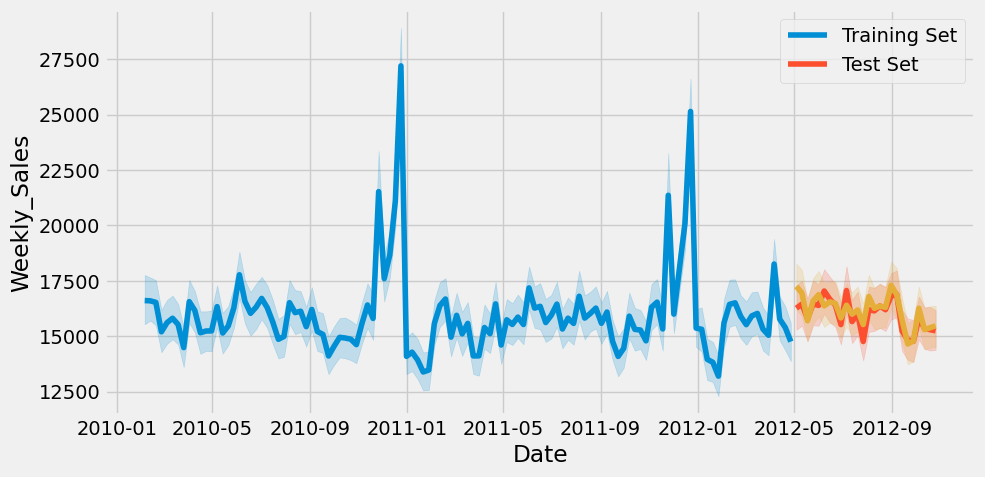

In [16]:
train = df_train.loc[df_train.index < "2012-05-01"]
test = df_train.loc[df_train.index >= "2012-05-01"]

fig, ax = plt.subplots(figsize=((10,5)))
sns.lineplot(x=train.index,y=train.Weekly_Sales)
sns.lineplot(x=test.index,y=test.Weekly_Sales)
sns.lineplot(x=test.index,y=test_predict)
ax.legend(['Training Set','_nolegend_','Test Set','_nolegend_'])
plt.show()

In [17]:
score = np.sqrt(mean_squared_error(test_predict,test['Weekly_Sales']))
print(f'RMSE score on Test Set : {score:0.2f}')

RMSE score on Test Set : 4122.58


## Predicting the weakly sales of test set using XGB Regressor

In [18]:
regressor = xgb.XGBRegressor(base_score=0.5, booster='gbtree',n_estimators=1000,max_depth=15)
regressor.fit(X_train, Y_train,verbose = 100)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [19]:
df_test = pd.read_csv('data/test.csv')
df_test= df_test.set_index('Date')
df_test.index = pd.to_datetime(df_test.index)
df_test.sort_index(ascending=True,inplace=True)

In [20]:
df_test = create_features(df_test)
df_test

,Store,Dept,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Week,Year,ModType,IsChristmas,IsThanksgiving
Date,,,,,,,,,,,,,,,,,,,
2010-02-05,39,32,False,44.30,2.572,NaN,NaN,NaN,NaN,NaN,209.852966,8.554,A,184109,5,2010,1,0,0
2010-02-05,43,32,False,47.31,2.572,NaN,NaN,NaN,NaN,NaN,203.064274,9.521,C,41062,5,2010,3,0,0
2010-02-05,24,54,False,22.43,2.954,NaN,NaN,NaN,NaN,NaN,131.527903,8.326,A,203819,5,2010,1,0,0
2010-02-05,28,72,False,49.47,2.962,NaN,NaN,NaN,NaN,NaN,126.442065,13.975,A,206302,5,2010,1,0,0
2010-02-05,4,4,False,43.76,2.598,NaN,NaN,NaN,NaN,NaN,126.442065,8.623,A,205863,5,2010,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-10-26,18,12,False,56.09,3.917,5430.61,128.31,50.0,822.64,969.64,138.728161,8.243,B,120653,43,2012,2,0,0
2012-10-26,33,12,False,73.70,4.301,122.41,13.71,NaN,NaN,965.49,131.193097,6.895,A,39690,43,2012,1,0,0
2012-10-26,35,55,False,58.99,3.882,6221.06,42.48,103.0,273.90,996.79,142.762411,8.665,B,103681,43,2012,2,0,0


In [21]:
X_test = df_test.loc[:,features]
Y_pred = regressor.predict(X_test)

C:\Users\USER\AppData\Local\Temp\ipykernel_17356\914245395.py:4: UserWarning: The label '_nolegend_' of <matplotlib.collections.PolyCollection object at 0x000001E6142D9C50> starts with '_'. It is thus excluded from the legend.
  plt.legend(["Actual data",'_nolegend_',"Predicted data",'_nolegend_'])
C:\Users\USER\AppData\Local\Temp\ipykernel_17356\914245395.py:4: UserWarning: The label '_nolegend_' of <matplotlib.collections.PolyCollection object at 0x000001E6142ED310> starts with '_'. It is thus excluded from the legend.
  plt.legend(["Actual data",'_nolegend_',"Predicted data",'_nolegend_'])


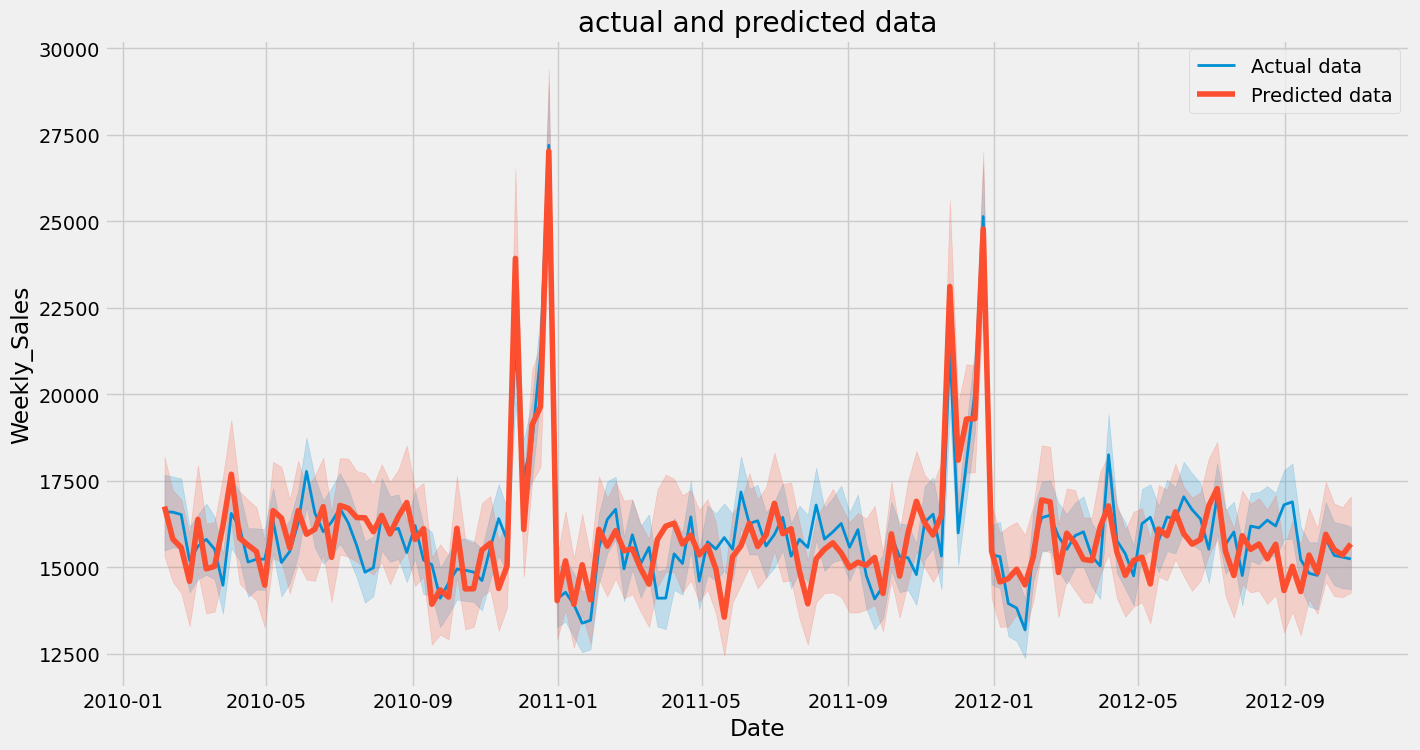

In [22]:
fig, axs = plt.subplots(figsize=(15, 8))
sns.lineplot(x=X_train.index,y=Y_train,size=3,legend=False)
sns.lineplot(x=X_test.index,y=Y_pred)
plt.legend(["Actual data",'_nolegend_',"Predicted data",'_nolegend_'])
axs.set_title("actual and predicted data")
plt.show()

## Train / Test Split for Random Forest regressor

In [23]:
# random forest cannot handle none value data set.
X_train = X_train.fillna(0)
Y_train = Y_train.fillna(0)

In [24]:
from sklearn.ensemble import RandomForestRegressor
regressor1 = RandomForestRegressor(max_depth=25,random_state=0)
regressor1.fit(train[features].fillna(0), train[target])

RandomForestRegressor(max_depth=25, random_state=0)

In [25]:
test_predict = regressor1.predict(test[features].fillna(0))

C:\Users\USER\AppData\Local\Temp\ipykernel_17356\2800373951.py:8: UserWarning: The label '_nolegend_' of <matplotlib.collections.PolyCollection object at 0x000001E613D19010> starts with '_'. It is thus excluded from the legend.
  ax.legend(['Training Set','_nolegend_','Test Set','_nolegend_'])
C:\Users\USER\AppData\Local\Temp\ipykernel_17356\2800373951.py:8: UserWarning: The label '_nolegend_' of <matplotlib.collections.PolyCollection object at 0x000001E612570810> starts with '_'. It is thus excluded from the legend.
  ax.legend(['Training Set','_nolegend_','Test Set','_nolegend_'])


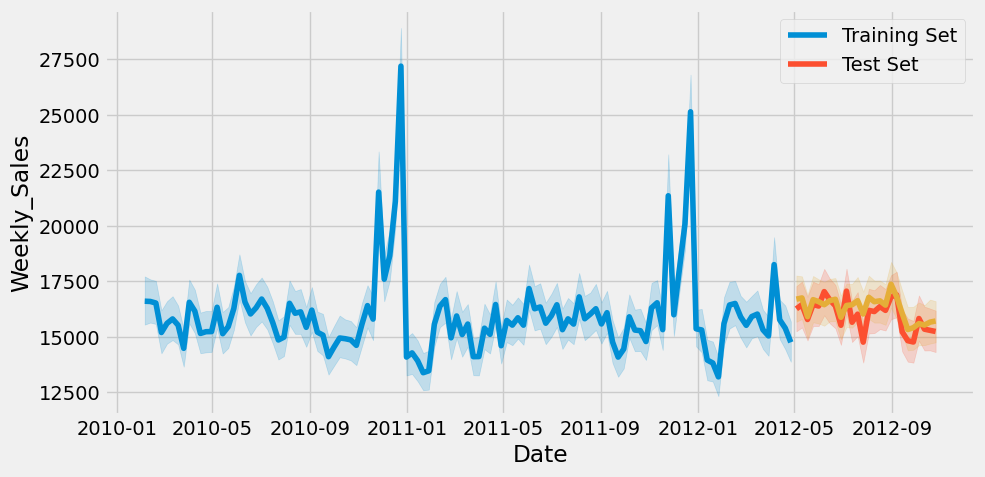

In [26]:
train = df_train.loc[df_train.index < "2012-05-01"]
test = df_train.loc[df_train.index >= "2012-05-01"]

fig, ax = plt.subplots(figsize=((10,5)))
sns.lineplot(x=train.index,y=train.Weekly_Sales)
sns.lineplot(x=test.index,y=test.Weekly_Sales)
sns.lineplot(x=test.index,y=test_predict)
ax.legend(['Training Set','_nolegend_','Test Set','_nolegend_'])
plt.show()

In [27]:
score = np.sqrt(mean_squared_error(test_predict,test['Weekly_Sales']))
print(f'RMSE score on Test Set : {score:0.2f}')

RMSE score on Test Set : 4001.46


## Predicting the weakly sales of test set using random forest Regressor

In [28]:
regressor1.fit(X_train, Y_train)

RandomForestRegressor(max_depth=25, random_state=0)

In [29]:
X_test=X_test.fillna(0)

In [30]:
y_pred = regressor1.predict(X_test)

C:\Users\USER\AppData\Local\Temp\ipykernel_17356\2265601535.py:4: UserWarning: The label '_nolegend_' of <matplotlib.collections.PolyCollection object at 0x000001E6142EE910> starts with '_'. It is thus excluded from the legend.
  plt.legend(["Actual data",'_nolegend_',"Predicted data",'_nolegend_'])
C:\Users\USER\AppData\Local\Temp\ipykernel_17356\2265601535.py:4: UserWarning: The label '_nolegend_' of <matplotlib.collections.PolyCollection object at 0x000001E6142F9590> starts with '_'. It is thus excluded from the legend.
  plt.legend(["Actual data",'_nolegend_',"Predicted data",'_nolegend_'])


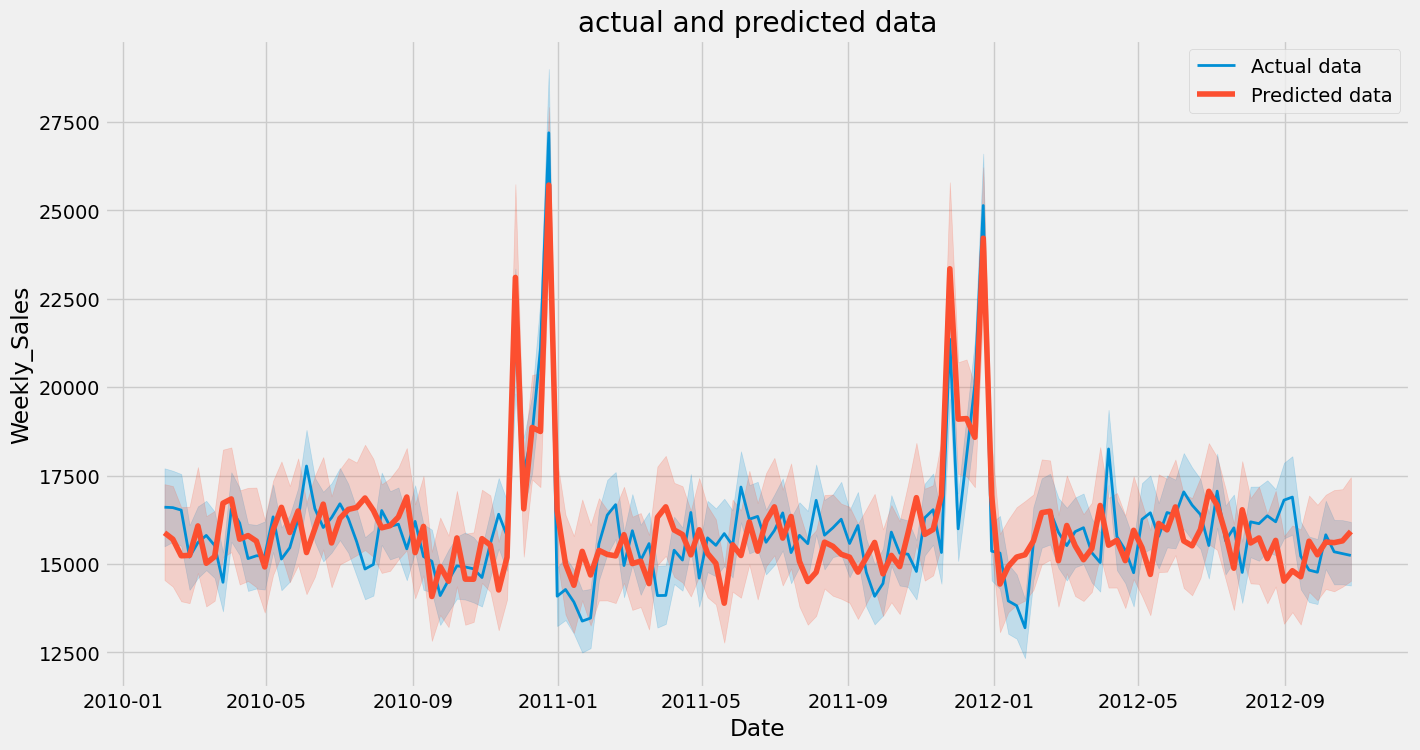

In [31]:
fig, axs = plt.subplots(figsize=(15, 8))
sns.lineplot(x=X_train.index,y=Y_train,size=3,legend=False)
sns.lineplot(x=X_test.index,y=y_pred)
plt.legend(["Actual data",'_nolegend_',"Predicted data",'_nolegend_'])
axs.set_title("actual and predicted data")
plt.show()

## Here I'm going to took average of predicted data from different model

In [32]:
y_pred_avg =  (y_pred+Y_pred)/2
y_pred_avg

array([5840.32142083,  104.202703  ,  410.20271502, ..., 7767.87012529,
        141.84500128,  398.01542603])

C:\Users\USER\AppData\Local\Temp\ipykernel_17356\2862110245.py:4: UserWarning: The label '_nolegend_' of <matplotlib.collections.PolyCollection object at 0x000001E61429E190> starts with '_'. It is thus excluded from the legend.
  plt.legend(["Actual data",'_nolegend_',"Predicted data",'_nolegend_'])
C:\Users\USER\AppData\Local\Temp\ipykernel_17356\2862110245.py:4: UserWarning: The label '_nolegend_' of <matplotlib.collections.PolyCollection object at 0x000001E620C740D0> starts with '_'. It is thus excluded from the legend.
  plt.legend(["Actual data",'_nolegend_',"Predicted data",'_nolegend_'])


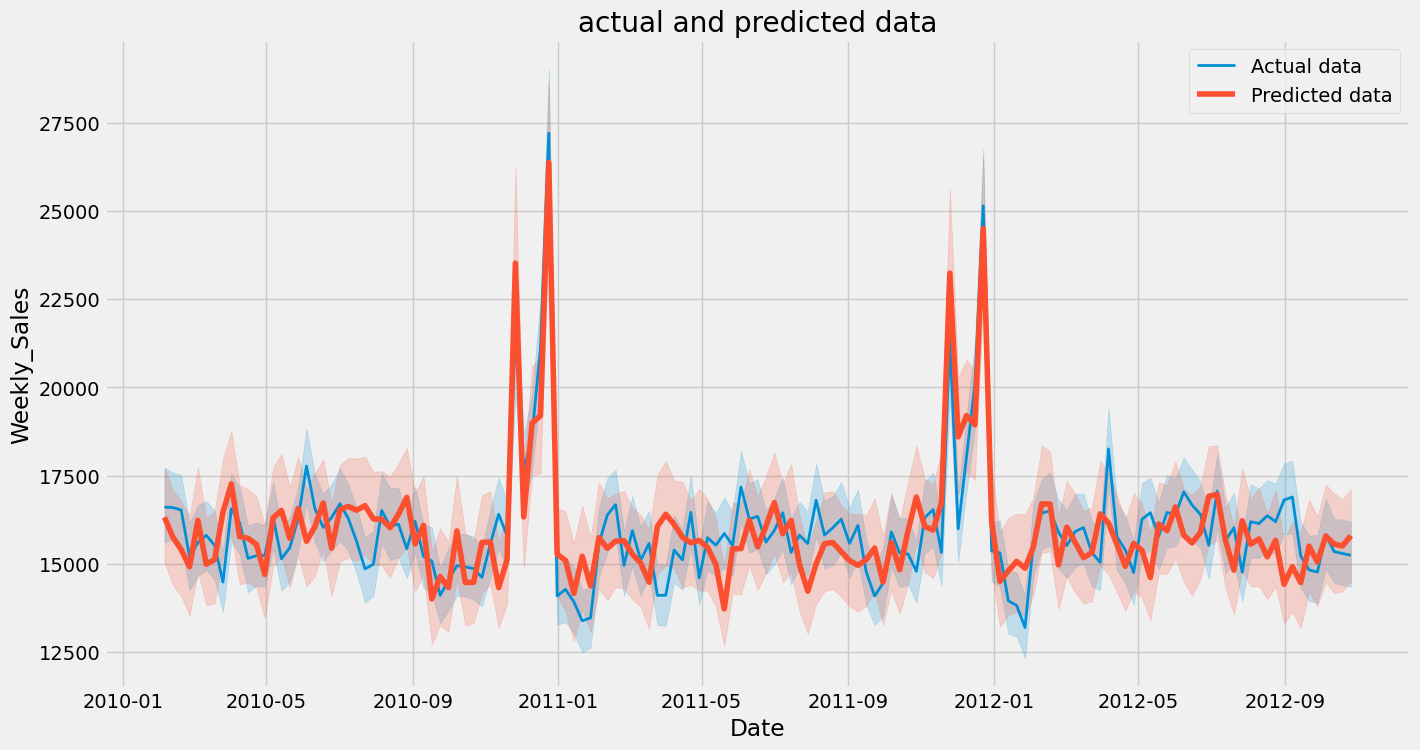

In [33]:
fig, axs = plt.subplots(figsize=(15, 8))
sns.lineplot(x=X_train.index,y=Y_train,size=3,legend=False)
sns.lineplot(x=X_test.index,y=y_pred_avg)
plt.legend(["Actual data",'_nolegend_',"Predicted data",'_nolegend_'])
axs.set_title("actual and predicted data")
plt.show()

## Saving this result in local files

In [36]:
result = pd.Series(y_pred_avg,index=X_test.index)
result.to_csv("data/submission.csv")